![](https://d33wubrfki0l68.cloudfront.net/d5cbc4b0e14c20f877366b69b9171649afe11fda/d96a8/assets/images/bigram-hmm/pos-title.jpg)

# Introduction

When creating machine learning models using NLP, people generally tend to use techniques that deal directly with the words in the text, such as bag of words. However, one could wonder, is there a difference between the frequency of adjectives, verbs and substantives in disasters tweets when compared to common tweets? This is a good technique when dealing with long texts (above 100 words usually), but maybe it's worth trying it here. It has also been tested to detect fake news with a very good accuracy [by the authors of this github repo](https://github.com/roneysco/Fake.br-Corpus).

Quoting wikipedia,
> In corpus linguistics, part-of-speech tagging (POS tagging or PoS tagging or POST), also called grammatical tagging or word-category disambiguation, is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its definition and its context—i.e., its relationship with adjacent and related words in a phrase, sentence, or paragraph. A simplified form of this is commonly taught to school-age children, in the identification of words as nouns, verbs, adjectives, adverbs, etc. 

Basically, what we want to do is to use NLTK library to pos-tag a sentence and count the number of each class on them. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import re
import matplotlib.pyplot as plt
from collections import Counter

import os



In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train["isTrain"] = True
test["isTrain"] = False

full = pd.concat([train, test])
full

,id,keyword,location,text,target,isTrain
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,True
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,False
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,False
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,False
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,False


# Feature engineering

The number of links and tags (like @Someone) seem to be important factors, as we tend to share links to the actual news when talking about disasters. Hashtags also seem to be important, along with the their number on a specific tweet, so we'll track those as well.

In [4]:
def get_at(row):
    return re.findall("@[\w]+", row["text"])

def get_http(row):
    return re.findall("http[\:\/\.\w]+", row["text"])

def get_hashtags(row):
    return re.findall("#[\w]+", row["text"])

def number_of_tags(row):
    return len(row["tags"])

def number_of_links(row):
    return len(row["links"])

def number_of_hashs(row):
    return len(row["hashtags"])

def clean_text(row):
    clean = row["text"]
    
    if len(row["tags"]) != 0:
        for word in row["tags"]:
            clean = clean.replace(word, "")
    
    if len(row["links"]) != 0:
        for word in row["links"]:
            clean = clean.replace(word, "")
    
    #only remove the # symbol
    clean = clean.replace("#", "").replace("/", "").replace("(", "").replace(")", "")
    
    return clean.strip()

full["tags"] = full.apply(lambda row: get_at(row), axis = 1)
full["links"] = full.apply(lambda row: get_http(row), axis = 1)
full["hashtags"] = full.apply(lambda row: get_hashtags(row), axis = 1)

full["number_of_tags"] = full.apply(lambda row: number_of_tags(row), axis = 1)
full["number_of_links"] = full.apply(lambda row: number_of_links(row), axis = 1)
full["number_of_hashs"] = full.apply(lambda row: number_of_hashs(row), axis = 1)

full["clean_text"] = full.apply(lambda row: clean_text(row), axis = 1)
full.sample(5)

,id,keyword,location,text,target,isTrain,tags,links,hashtags,number_of_tags,number_of_links,number_of_hashs,clean_text
7349,10521,wildfire,NaN,Reuters Top News: PHOTOS: The Rocky Fire has g...,1.0,True,[],"[http://t.co/qwrRfDGXCc, http://t.co/sstj2bEpqn]",[#NewsInTweets],0,2,1,Reuters Top News: PHOTOS: The Rocky Fire has g...
5978,8538,screaming,9/1/13,SCREAMING IN 22 DIFFERENT LANGUAGES http://t.c...,0.0,True,[],[http://t.co/rDfaAKKbNJ],[],0,1,0,SCREAMING IN 22 DIFFERENT LANGUAGES
5212,7444,obliterated,NaN,I think I'll get obliterated tonight,0.0,True,[],[],[],0,0,0,I think I'll get obliterated tonight
2639,8821,sirens,Atrapada en el mundo.,Sleeping With Sirens - 2 Chord,NaN,False,[],[],[],0,0,0,Sleeping With Sirens - 2 Chord
3890,5531,flattened,NaN,Conklin being flattened. Shuffled feet instead...,0.0,True,[],[http://t.co/67TjN9EgyK],[],0,1,0,Conklin being flattened. Shuffled feet instead...


We have cleaned our texts and stored links, hashtags and tags, it's time for the real deal. We'll first tokenize our texts and use them to get our grammatical classes.

In [5]:
from nltk.tokenize import word_tokenize

def get_tokens(row):
    return word_tokenize(row["clean_text"].lower())

full["tokens"] = full.apply(lambda row: get_tokens(row), axis = 1)
full.sample(5, random_state = 4)

,id,keyword,location,text,target,isTrain,tags,links,hashtags,number_of_tags,number_of_links,number_of_hashs,clean_text,tokens
193,626,arsonist,"Toronto, Canada",ARSONIST Mc - CHRIST WALK http://t.co/D8LQHiGj...,NaN,False,[],[http://t.co/D8LQHiGjT0],"[#Toronto, #Columbus, #Gospel]",0,1,3,ARSONIST Mc - CHRIST WALK Toronto Columbus Go...,"[arsonist, mc, -, christ, walk, toronto, colum..."
3145,4519,emergency,NaN,STL Ace Grille - Surface Mounts SpeedTech Ligh...,0.0,True,[],"[http://t.co/t6Seku4yvm, http://t.co/TJOZ4u4txl]",[],0,2,0,STL Ace Grille - Surface Mounts SpeedTech Ligh...,"[stl, ace, grille, -, surface, mounts, speedte..."
7034,10080,typhoon,REPUBLICA DOMINICANA,(#LosDelSonido) Obama Declares Disaster for Ty...,1.0,True,[],[],"[#LosDelSonido, #IvanBerroa]",0,0,2,LosDelSonido Obama Declares Disaster for Typho...,"[losdelsonido, obama, declares, disaster, for,..."
2379,3419,derail,NaN,Will @FoxNews continue to derail the Iran Nucl...,1.0,True,[@FoxNews],[],[#GOPDebate],1,0,1,Will continue to derail the Iran Nuclear Deal...,"[will, continue, to, derail, the, iran, nuclea..."
5984,8545,screams,xiumin's nonexistent solos,//screams in the distance// http://t.co/Cfe9HU...,1.0,True,[],[http://t.co/Cfe9HUQN0h],[],0,1,0,screams in the distance,"[screams, in, the, distance]"


In [6]:
# s = ["screams", "in", "the", "distance"]

def get_postags(row):
    
    postags = nltk.pos_tag(row["tokens"])
    list_classes = list()
    for  word in postags:
        list_classes.append(word[1])
    
    return list_classes

full["postags"] = full.apply(lambda row: get_postags(row), axis = 1)
full.sample(5, random_state = 4)
# nltk.help.upenn_tagset('NNS')

,id,keyword,location,text,target,isTrain,tags,links,hashtags,number_of_tags,number_of_links,number_of_hashs,clean_text,tokens,postags
193,626,arsonist,"Toronto, Canada",ARSONIST Mc - CHRIST WALK http://t.co/D8LQHiGj...,NaN,False,[],[http://t.co/D8LQHiGjT0],"[#Toronto, #Columbus, #Gospel]",0,1,3,ARSONIST Mc - CHRIST WALK Toronto Columbus Go...,"[arsonist, mc, -, christ, walk, toronto, colum...","[NN, SYM, :, NN, NN, IN, NN, NN]"
3145,4519,emergency,NaN,STL Ace Grille - Surface Mounts SpeedTech Ligh...,0.0,True,[],"[http://t.co/t6Seku4yvm, http://t.co/TJOZ4u4txl]",[],0,2,0,STL Ace Grille - Surface Mounts SpeedTech Ligh...,"[stl, ace, grille, -, surface, mounts, speedte...","[JJ, NN, SYM, :, NN, NNS, JJ, NNS, :, NN, NN, ..."
7034,10080,typhoon,REPUBLICA DOMINICANA,(#LosDelSonido) Obama Declares Disaster for Ty...,1.0,True,[],[],"[#LosDelSonido, #IvanBerroa]",0,0,2,LosDelSonido Obama Declares Disaster for Typho...,"[losdelsonido, obama, declares, disaster, for,...","[JJ, NN, VBZ, NN, IN, JJ, NN, :, NN, NNS, NN, ..."
2379,3419,derail,NaN,Will @FoxNews continue to derail the Iran Nucl...,1.0,True,[@FoxNews],[],[#GOPDebate],1,0,1,Will continue to derail the Iran Nuclear Deal...,"[will, continue, to, derail, the, iran, nuclea...","[MD, VB, TO, VB, DT, NN, JJ, NN, IN, NN, POS, ..."
5984,8545,screams,xiumin's nonexistent solos,//screams in the distance// http://t.co/Cfe9HU...,1.0,True,[],[http://t.co/Cfe9HUQN0h],[],0,1,0,screams in the distance,"[screams, in, the, distance]","[NNS, IN, DT, NN]"


Now we have the POS tags for every text. There are lots of categories and I'll focus only in a few of them. Here are the meanings:

- NN: noun (there are other categories that can fit within this one for our purposes, such as NNS, NNP, NNPS, which all belong to nouns, containing plurals and proper names)
- RB: adverb
- VB: verb (and similar categories indicating tense: VBP, VBG, VBS..)
- JJ: adjective or numeral


**Note:** *If you want to get more information about the classes that pos_tag can identify, use the command `nltk.help.upenn_tagset("NNS")` for instance. If you want to see all the similar categories, you can just write the first letter of the class: `nltk.help.upenn_tagset("N")`.*

In [7]:
def find_no_class(count, class_name = ""):
    total = 0
    for key in count.keys():
        if key.startswith(class_name):
            total += count[key]
            
            
    return total

def get_classes(row, grammatical_class = ""):
    count = Counter(row["postags"])
    return find_no_class(count, class_name = grammatical_class)/len(row["postags"])

full["freqAdverbs"] = full.apply(lambda row: get_classes(row, "RB"), axis = 1)
full["freqVerbs"] = full.apply(lambda row: get_classes(row, "VB"), axis = 1)
full["freqAdjectives"] = full.apply(lambda row: get_classes(row, "JJ"), axis = 1)
full["freqNouns"] = full.apply(lambda row: get_classes(row, "NN"), axis = 1)

full.sample(5)

,id,keyword,location,text,target,isTrain,tags,links,hashtags,number_of_tags,number_of_links,number_of_hashs,clean_text,tokens,postags,freqAdverbs,freqVerbs,freqAdjectives,freqNouns
1846,2656,crush,Houma La,Womem Crush Wednesday ?????????????????? @momm...,0.0,True,[@mommyisbomb],[],[],1,0,0,Womem Crush Wednesday ??????????????????,"[womem, crush, wednesday, ?, ?, ?, ?, ?, ?, ?,...","[NN, NN, NN, ., ., ., ., ., ., ., ., ., ., ., ...",0.000000,0.000000,0.000000,0.142857
3119,4479,electrocuted,"Redondo Beach, CA",Do babies actually get electrocuted from wall ...,1.0,True,[],[],[],0,0,0,Do babies actually get electrocuted from wall ...,"[do, babies, actually, get, electrocuted, from...","[VB, NNS, RB, VBP, VBN, IN, NN, NNS, ., JJ, VB...",0.047619,0.285714,0.095238,0.190476
864,2834,cyclone,NaN,Is that a hurricane or a typhoon? No matter wh...,NaN,False,[],[http://t.co/c5kJAtjgzn],[],0,1,0,Is that a hurricane or a typhoon? No matter wh...,"[is, that, a, hurricane, or, a, typhoon, ?, no...","[VBZ, IN, DT, NN, CC, DT, NN, ., DT, NN, WDT, ...",0.055556,0.166667,0.000000,0.222222
6936,9946,trouble,Manila City,@charlieputh that song have a Cool beat like N...,0.0,True,[@charlieputh],[],[],1,0,0,that song have a Cool beat like Nothing But Tr...,"[that, song, have, a, cool, beat, like, nothin...","[IN, NN, VBP, DT, JJ, NN, IN, NN, CC, NN]",0.000000,0.100000,0.100000,0.400000
6191,8838,sirens,NaN,I added a video to a @YouTube playlist http://...,0.0,True,[@YouTube],[http://t.co/f2TqMFh1Yb],[],1,1,0,I added a video to a playlist Cher Lloyd - S...,"[i, added, a, video, to, a, playlist, cher, ll...","[NN, VBD, DT, NN, TO, DT, NN, NN, SYM, :, NNS]",0.000000,0.090909,0.000000,0.454545


In [8]:
training = full.loc[full["isTrain"] == True, :].copy()
testing = full.loc[full["isTrain"] == False, :].copy()

## A few visualizations of the POS for disaster and non-disaster tweets

Note: non-disaster tweets are shown in blue

### Noun frequency

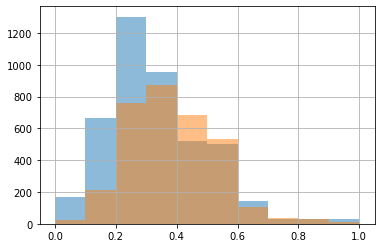

In [9]:
training.loc[training["target"] == 0.0, "freqNouns"].hist(alpha = 0.5);
training.loc[training["target"] == 1.0, "freqNouns"].hist(alpha = 0.5);

### Verb Frequency

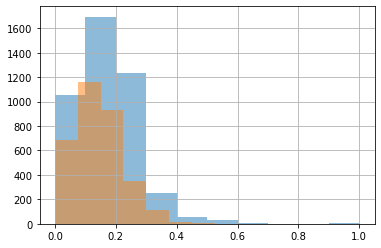

In [10]:
training.loc[training["target"] == 0.0, "freqVerbs"].hist(alpha = 0.5);
training.loc[training["target"] == 1.0, "freqVerbs"].hist(alpha = 0.5);

### Adjective frequency

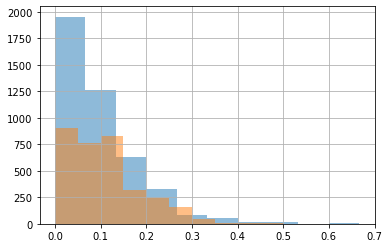

In [11]:
training.loc[training["target"] == 0.0, "freqAdjectives"].hist(alpha = 0.5);
training.loc[training["target"] == 1.0, "freqAdjectives"].hist(alpha = 0.5);

The distribution of frequencies for the three grammatical classes are about the same for disaster and non-disaster tweets.  The most prominent difference being the number of instances. In that case, we have more non-disaster than disaster tweets in the training dataset. This distribution study is very important to do because there are cases (such as fake news detection mentioned earlier) in which both distributions have statistically different distributions, and this fact may help in detection.

We are ready to make a first model out of the variables we have. Let's create a simple train-test split.

In [12]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

x = training.loc[:, ["number_of_tags", "number_of_links", "freqAdverbs", "freqVerbs", "freqAdjectives", "freqNouns"]]
y = training.loc[:, "target"]

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)

for train_index, test_index in skf.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
#     clf = GradientBoostingClassifier(learning_rate=0.1, max_depth= 5, max_features = 5,random_state = 42)
    clf = RandomForestClassifier(random_state = 42)
    
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    print(accuracy_score(y_test, preds))
    
    print(confusion_matrix(y_test, preds))


total_preds = clf.predict(x)
print("Confusion Matrix:")
confusion_matrix(y,total_preds)

TRAIN: [1342 1347 1348 ... 7610 7611 7612] TEST: [   0    1    2 ... 1737 1738 1739]
0.6250820748522653
[[622 246]
 [325 330]]
TRAIN: [   0    1    2 ... 7610 7611 7612] TEST: [1342 1347 1348 ... 3291 3292 3293]
0.6447800393959291
[[658 211]
 [330 324]]
TRAIN: [   0    1    2 ... 7610 7611 7612] TEST: [2846 2849 2851 ... 4658 4661 4665]
0.623768877216021
[[616 253]
 [320 334]]
TRAIN: [   0    1    2 ... 7610 7611 7612] TEST: [4510 4511 4512 ... 6292 6317 6321]
0.6373193166885677
[[621 247]
 [305 349]]
TRAIN: [   0    1    2 ... 6292 6317 6321] TEST: [5991 5992 5993 ... 7610 7611 7612]
0.668856767411301
[[656 212]
 [292 362]]
Confusion Matrix:


array([[3511,  831],
       [1230, 2041]], dtype=int64)

And the feature importance is

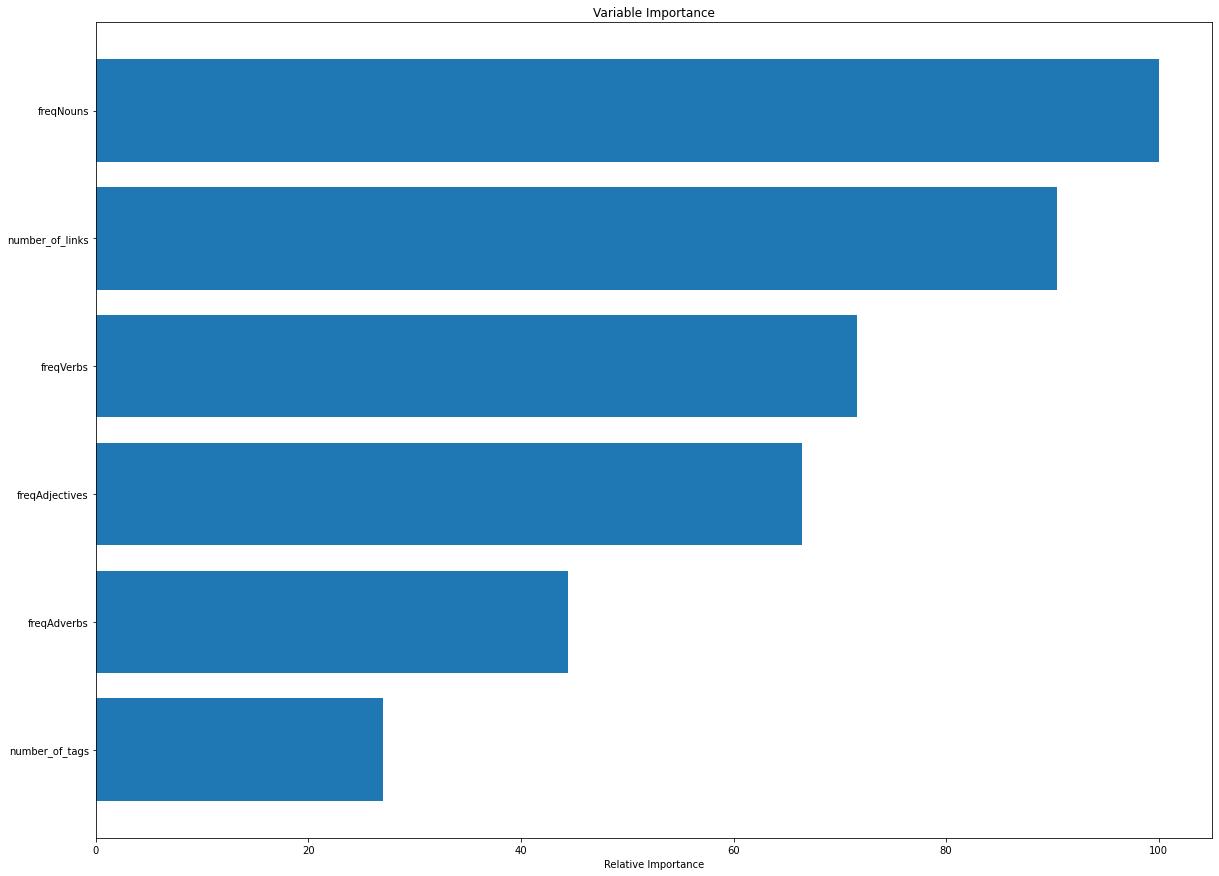

In [13]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

After a few tests, it seems that our simple model using only these engineered variables gave us approximately 60% accuracy. It is also evident that the number of links on a page plays a big role in detecting disaster tweets. Maybe this could be a variable used in other kernels to improve scores. Before ending the notebook, let's check the distribution of number of links for both disaster and non-disaster tweets.

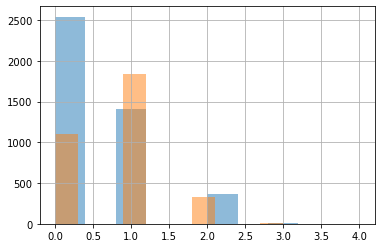

In [14]:
training.loc[training["target"] == 0.0, "number_of_links"].hist(alpha = 0.5);
training.loc[training["target"] == 1.0, "number_of_links"].hist(alpha = 0.5);

Indeed, most non-disaster tweets have no links at all, while most disaster ones have at least one.

Now we'll just score the test dataset and make the submission.

In [15]:
preds = clf.predict(testing.loc[:, ["number_of_tags", "number_of_links", "freqAdverbs", "freqVerbs", "freqAdjectives", "freqNouns"]])
testing["prediction"] = preds